# Data loading
**Importing modules**

---



In [ ]:
# Modules to import the data set from Github
import zipfile
import os
import pandas as pd

# Modules for linear classifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

# Modules for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Scaling
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

**Data Loading**


---


Below are functions to load the ECG dataset that contains frequency features of both normal and abnormal ECG's.

In [ ]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git

with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

Cloning into 'tm10007_ml'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 87 (delta 9), reused 8 (delta 8), pack-reused 72 (from 1)
Receiving objects: 100% (87/87), 67.99 MiB | 17.91 MiB/s, done.
Resolving deltas: 100% (31/31), done.


**Describtion of the dataset**


---

Before we can train classifiers, it is important to understand the data we will be working with. Therefore we give a short description of our dataset.

From this, we learn that:


*   The number of features in the dataset is a lot larger that the number of samples (curse of dimensionality).
*   There are no further actions required regarding missing values.
*   The number of normal ECGs in the dataset is a lot larger than the number of abnormal ECGs (imbalanced dataset).
*   The dataset contains many outliers, so scaling is required.
*   The features do not all follow a normal distribution.



The dataset contains 827 samples and 9000 features.
The dataset contains 0 missing values.
The dataset contains 681 normal ECGs, and  146 abnormal ECGs.


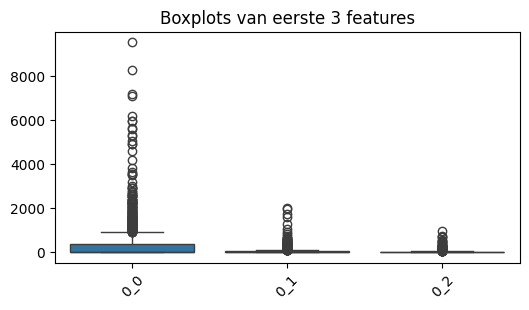

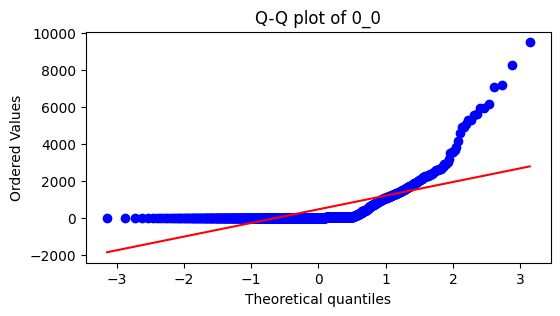

In [ ]:
# Samples and features
print(f'The dataset contains {len(data.index)} samples and {len(data.columns)-1} features.')

# Check for missing features
missing_total = data.isnull().sum().sum() #sum of NaNs
print (f'The dataset contains {(missing_total)} missing values.')

# Check imbalance of the dataset
print("The dataset contains",(data.iloc[:, -1] == 0).sum(), "normal ECGs, and ", (data.iloc[:, -1] == 1).sum(), "abnormal ECGs.")

# Plot boxplots van de features
features = data.columns[:-1][:3]
plt.figure(figsize=(6, 3))
sns.boxplot(data=data[features])
plt.title("Boxplots van eerste 3 features")
plt.xticks(rotation=45)
plt.show()

# Q-Q plot for one feature
feature = data.columns[0]
plt.figure(figsize=(6, 3))
stats.probplot(data[feature], dist="norm", plot=plt)
plt.title(f"Q-Q plot of {feature}")
plt.show()

# Preprocessing the data

**Creating a split in the data**



---

Before we take any other steps, it is important to split the data in a traning and test set. The training set will be used to train and validate the different classifiers, while the test set remains untouched until it is used to testing an already trained classifier.

We use *stratify* so the proportions of  normal and abnormal ECGs remains consistent across the training and test set, so that the model is evaluated on a representative sample of the data. Furthermore, a *random state* 7 was used to ensure the reproducibility of the plots presented in our report.

In [ ]:
# Splitting features and labels
x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

**Scaling the data**


---
As vizualized above, the dataset contains outliers. We apply *Robust Scaling*, as this scaling method is best for handling outliers. We choose to scale the data so that it will fall between the 25th and 75th percentiles.


In [ ]:
# Scale the features
scaler = RobustScaler(quantile_range=(25, 75))
x_scaled = scaler.fit_transform(x_train)

**Feature transformation - PCA**


---

As mentioned earlier, the dataset contains far more features than samples, which increases the change of overfitting and makes computation more challenging. To solve this, we use for *Principal Component Analysis* (PCA) for dimensionality reduction. We choose the PCA so that 99% of the variance in the set is preserved.

In [ ]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.99)
x_train_pca = pca.fit_transform(x_train)

# Print the number of features left
print(f"Dimensionality was reduced from {len(data.columns)-1} features to {x_train_pca.shape[1]} features after PCA.")

Dimensionality was reduced from 9000 features to 66 features after PCA 


# Classifiers
**Linear classifier**


---
We expect the linear classifier to perform poorly, as the data is expected to be non-linearly and not normally distributed. Nevertheless, we still train the linear classifier to confirm this expextation and demonstrate that accuracy alone is not a valid performance metric.

In [ ]:
# Code toevoegen hier

**Support Vector Machine**


---


In [ ]:
import os
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, accuracy_score,
    f1_score, precision_recall_curve, auc as pr_auc
)
from scipy.stats import loguniform, uniform

# Load data
data_path = os.path.join(os.getcwd(), 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

outer = range(10)
best_params_dict = {}
best_model_dict = {}
precision_list = []
recall_list = []
auc_list = []

for outer_rand in tqdm(outer, desc='Outer Loop'):
    X_train_outer, X_test_outer, y_train_outer, y_test_outer = train_test_split(
        x, y, test_size=0.2, stratify=y, shuffle=True, random_state=outer_rand
    )

    # Define pipeline
    pipeline = Pipeline([
        ('scaler', RobustScaler(quantile_range=(25, 75))),
        ('pca', PCA(n_components=0.99, random_state=42)),
        ('svc', SVC(kernel='rbf', probability=True))
    ])

    # Hyperparameter space for RandomizedSearchCV
    param_grid_svc = {
        'svc__C': loguniform(0.01, 1000),
        'svc__gamma': loguniform(0.0001, 100),
        'svc__class_weight': ['balanced', None],
        'svc__shrinking': [True, False],
        'svc__tol': uniform(1e-5, 1e-2)
    }

    cv_inner = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid_svc,
        scoring='roc_auc',
        cv=cv_inner,
        n_iter=10,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train_outer, y_train_outer)

    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    y_pred = best_model.predict(X_test_outer)
    y_pred_proba = best_model.predict_proba(X_test_outer)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test_outer, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    auc_score = roc_auc_score(y_test_outer, y_pred_proba)
    f1 = f1_score(y_test_outer, y_pred)
    accuracy = accuracy_score(y_test_outer, y_pred)

    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_proba)
    pr_score = pr_auc(recall, precision)

    best_params_dict[f"Outer {outer_rand}"] = {
        **best_params,
        'auc': auc_score,
        'f1': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'accuracy': accuracy,
        'pr_auc': pr_score
    }
    best_model_dict[f"Outer {outer_rand}"] = best_model

    precision_list.append(precision)
    recall_list.append(recall)
    auc_list.append(pr_score)

    # Save best parameters
    results_df = pd.DataFrame.from_dict(best_params_dict, orient='index')
    results_csv_path = os.path.join(os.getcwd(), 'svm_best_hyperparameters_randomsearch.csv')
    results_df.to_csv(results_csv_path)

    # Save PR curve data
    pr_data = {
        "precision_list": precision_list,
        "recall_list": recall_list,
        "auc_list": auc_list
    }
    pr_data_path = os.path.join(os.getcwd(), 'svm_precision_recall_data_randomsearch.pkl')
    with open(pr_data_path, 'wb') as f:
        pickle.dump(pr_data, f)

# Load PR curve data
with open(pr_data_path, 'rb') as f:
    pr_data = pickle.load(f)

precision_list = pr_data["precision_list"]
recall_list = pr_data["recall_list"]
auc_list = pr_data["auc_list"]

mean_recall = np.linspace(0, 1, 100)
interp_precisions = []

for precision, recall in zip(precision_list, recall_list):
    order = np.argsort(recall)
    recall_sorted = recall[order]
    precision_sorted = precision[order]
    interp = np.interp(mean_recall, recall_sorted, precision_sorted, left=1.0, right=0.0)
    interp_precisions.append(interp)

mean_precision = np.mean(interp_precisions, axis=0)
std_precision = np.std(interp_precisions, axis=0)

plt.figure(figsize=(8, 6))
plt.plot(mean_recall, mean_precision, label=f"Mean PR Curve (AUC = {np.mean(auc_list):.2f})", color='purple')
plt.fill_between(mean_recall, mean_precision - std_precision, mean_precision + std_precision,
                 alpha=0.2, color='violet', label="±1 Std. Dev.")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("SVM Precision-Recall Curve (Mean ± Std) - RandomSearchCV")
plt.legend(loc="lower left")
plt.grid()
plt.tight_layout()

plot_path = os.path.join(os.getcwd(), 'svm_pr_curve_randomsearch.png')
plt.savefig(plot_path)
plt.show()


print(f"Saved PR curve plot to {plot_path}")
